# Multivariant Gaussian distribution estimation in pymc3

## Generate data

In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import scipy as sp
%matplotlib inline

N = 500
mean = sp.stats.uniform.rvs(-5, 10, size=2)
cov_actual_sqrt = sp.stats.uniform.rvs(0, 2, size=(2, 2))
covariance = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)
data = sp.stats.multivariate_normal.rvs(mean, covariance, size=N)

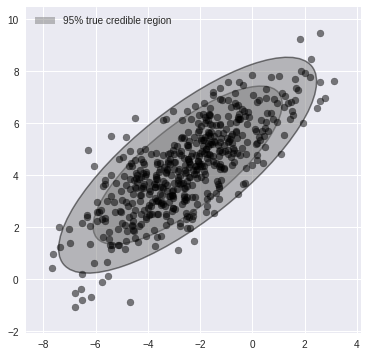

In [2]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1]/u[0])
    angle = 180 * angle / np.pi # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * chi2.ppf(level, 2)) #get size corresponding to level
        ell = Ellipse(mu[:2], v[0], v[1], 180 + angle, facecolor='gray',
                      edgecolor='k',
                      alpha=(1-level)*.5,
                      lw=1.5)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    
    return ax

_, ax = plt.subplots(figsize=(6, 6))
Gauss2d(mean, covariance, [.8, .95], ax)
ax.scatter(data[:, 0], data[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
ax.legend([rect], ['95% true credible region'], loc=2);
ax.set_xlim(min(data[:, 0])-1, max(data[:, 0])+1)
ax.set_ylim(min(data[:, 1])-1, max(data[:, 1])+1);

## Fitting using GMM

In [3]:
from sklearn.mixture import GaussianMixture
g = GaussianMixture(n_components=1, covariance_type='full')
g.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

## Using Wishart prior
Code steal from [Thomas Wiecki](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94639178)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:14<00:00, 136.30it/s]


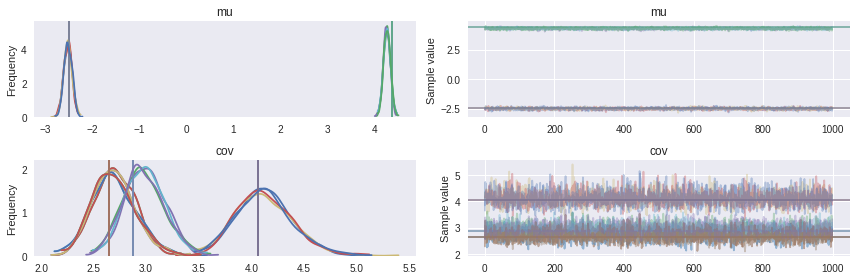

In [6]:
S = np.matrix([[1, .5],
               [.5, 1]])
L = scipy.linalg.cholesky(S)
nu = 5

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=10, shape=2)
    c = tt.sqrt(pm.ChiSquared('c', nu - np.arange(2, 4), shape=2))
    z = pm.Normal('z', 0, 1)
    A = tt.stacklists([[c[0], 0], 
                      [z, c[1]]])

    # L * A * A.T * L.T ~ Wishart(L*L.T, nu)
    wishart = pm.Deterministic('wishart', tt.dot(tt.dot(tt.dot(L, A), A.T), L.T))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_inverse(wishart))
    lp = pm.MvNormal('likelihood', mu=mu, tau=wishart, observed=data)

    trace1 = pm.sample(1000, tune=1000, njobs=4)

pm.traceplot(trace1, varnames=['mu','cov'],
            lines=dict(mu=mean, cov=covariance));

## Using LKJ prior

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:19<00:00, 101.09it/s]


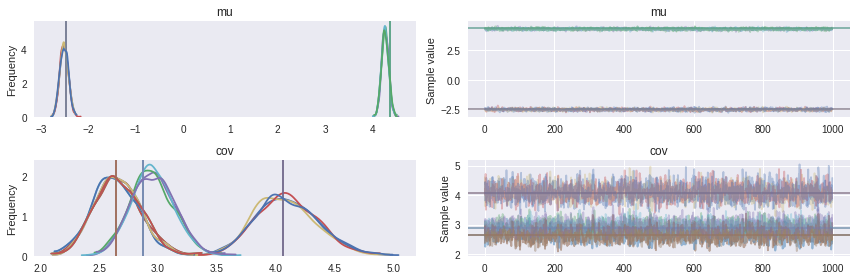

In [17]:
Nd = 2
n_elem = int(Nd * (Nd - 1) / 2)
tri_index = np.zeros([Nd, Nd], dtype=int)
tri_index[np.triu_indices(Nd, k=1)] = np.arange(n_elem)
tri_index[np.triu_indices(Nd, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model:
    sd = pm.Lognormal('sigma', 0, 1, shape=2)
    nu = 5
    corr_triangle = pm.LKJCorr('r', eta=nu, n=2)
    corr_matrix = corr_triangle[tri_index]
    corr_matrix = tt.fill_diagonal(corr_matrix, 1)

    cov = pm.Deterministic('cov', tt.diag(sd).dot(corr_matrix.dot(tt.diag(sd))))
    
    mu = pm.Normal('mu', mu=0, sd=10, shape=2)
    
    x_ = pm.MvNormal('x', mu, cov, observed=data)
    trace2 = pm.sample(1000, tune=1000, njobs=4)
    
pm.traceplot(trace2, varnames=['mu','cov'],
            lines=dict(mu=mean, cov=covariance));

## Using LKJCholeskyCov prior

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:06<00:00, 331.39it/s]


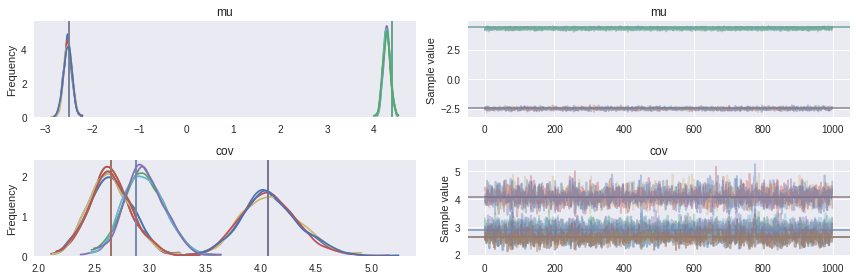

In [18]:
with pm.Model() as model:
    sigma_dist = pm.Lognormal.dist(0, 1)
    nu = 5
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=nu, n=2, sd_dist=sigma_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    
    mu = pm.Normal('mu', mu=0, sd=10, shape=2)
    x_ = pm.MvNormal('x', mu, chol=chol, observed=data)
    
    trace3 = pm.sample(1000, tune=1000, njobs=4)
    
pm.traceplot(trace3, varnames=['mu','cov'],
            lines=dict(mu=mean, cov=covariance));

## Show result

In [21]:
print ("Mean ", mean)
print ("Mean from GMM", g.means_)
print ("Mean from Wishart Prior",np.mean(trace1['mu'], axis=0))
print ("Mean from LKJ Prior",np.mean(trace2['mu'], axis=0))
print ("Mean from LKJCholeskyCov Prior",np.mean(trace3['mu'], axis=0))

post_cov1 = trace1['cov'].mean(axis=0)
post_cov2 = trace2['cov'].mean(axis=0)
post_cov3 = trace3['cov'].mean(axis=0)

print ('  ')
print ("Covariance Matrix")
print (covariance)
print ("Covariance Matrix from GMM")
print(g.covariances_)
print ("Covariance Matrix from Wishart Prior")
print(post_cov1)
print ("Covariance Matrix from LKJ Prior")
print(post_cov2)
print ("Covariance Matrix from LKJCholeskyCov Prior")
print(post_cov3)

Mean  [-2.47980208  4.37650211]
Mean from GMM [[-2.51282267  4.27187534]]
Mean from Wishart Prior [-2.51243699  4.27144076]
Mean from LKJ Prior [-2.51419246  4.27052212]
Mean from LKJCholeskyCov Prior [-2.51409314  4.27053159]
  
Covariance Matrix
[[ 4.06413249  2.64816601]
 [ 2.64816601  2.87692723]]
Covariance Matrix from GMM
[[[ 4.11145671  2.69348253]
  [ 2.69348253  2.97461691]]]
Covariance Matrix from Wishart Prior
[[ 4.12416796  2.69725508]
 [ 2.69725508  2.98198682]]
Covariance Matrix from LKJ Prior
[[ 4.08934075  2.65438024]
 [ 2.65438024  2.95766846]]
Covariance Matrix from LKJCholeskyCov Prior
[[ 4.08466452  2.64870878]
 [ 2.64870878  2.95309539]]
